In [1]:
import os
import difflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches as mpatches

import sys
sys.path.append('../../')
from rllte.evaluation.visualization import _annotate_and_decorate_axis, plot_interval_estimates
from rllte.evaluation import Performance

In [2]:
for ds in ['q7']:
    root = f'/Users/yuanmingqi/Downloads/nips2024_data/{ds}'
    for folder in os.listdir(root):
        if folder == '.DS_Store':
            continue
        if len(os.listdir(os.path.join(root, folder))) != 1:
            print(folder, os.listdir(os.path.join(root, folder)))
    
    algos = ['ICM', 'Disagreement', 'E3B', 'RND', 'PseudoCounts', 'RIDE', 'RE3', 'NGU']
    num_points = 10
    all_data = {algo: [] for algo in algos}
    for algo in algos:
        for dir in os.listdir(root):
            if algo.lower() in dir:
                file = f"{root}/{dir}/"
                file = file + difflib.get_close_matches("2024-", os.listdir(file), 1, 0.1)[0] + '/train.log'
                data = pd.read_csv(file)#['episode_reward']
                if data['step'].values[-1] != 9999360:
                    print(file)

PPO_SuperMarioBrosRandomStages-v3_disagreement_obsRMS:True_rewNorm:none_updateProp:1.0_rff:False_s1 ['.DS_Store', '2024-02-19-05-26-43']


# q7 curves

ICM (5, 1, 10)
Disagreement (5, 1, 10)
E3B (5, 1, 10)
RND (5, 1, 10)
PseudoCounts (5, 1, 10)
RIDE (5, 1, 10)
RE3 (5, 1, 10)
NGU (5, 1, 10)


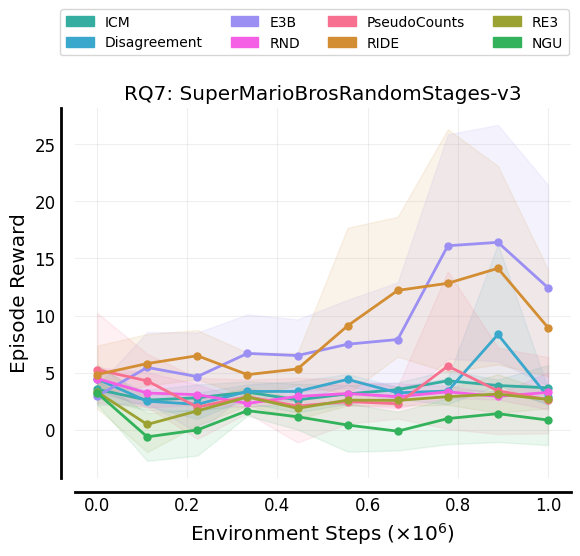

In [7]:
algos = ['ICM', 'Disagreement', 'E3B', 'RND', 'PseudoCounts', 'RIDE', 'RE3', 'NGU']
colors = sns.husl_palette(len(algos), h=.5)
fake_patches = [mpatches.Patch(color=colors[i], label=alg) for i, alg in enumerate(algos)]

root = "/Users/yuanmingqi/Downloads/nips2024_data/q7"
num_points = 10
all_data = {algo: [] for algo in algos}
for algo in algos:
    for dir in os.listdir(root):
        if algo.lower() in dir:
            file = f"{root}/{dir}/"
            file = file + difflib.get_close_matches("2024-", os.listdir(file), 1, 0.1)[0] + '/train.log'
            data = pd.read_csv(file)['episode_reward']
            data = data[np.linspace(0, data.shape[0]-1, num_points, dtype=int)]
            all_data[algo].append(data)

    all_data[algo] = np.array(all_data[algo])
    all_data[algo] = np.expand_dims(all_data[algo], axis=1)
    print(algo, all_data[algo].shape)

sampling_dict = dict()
for algo in algos:
    sampling_dict[algo] = [[], [], []]
    for frame in range(num_points):
        perf = Performance(all_data[algo][:, :, frame], get_ci=True, reps=2000)
        value, CIs = perf.aggregate_mean()
        sampling_dict[algo][0].append(value)
        sampling_dict[algo][1].append(CIs[0]) # lower bound
        sampling_dict[algo][2].append(CIs[1]) # upper bound

    sampling_dict[algo][0] = np.array(sampling_dict[algo][0]).reshape(-1)
    sampling_dict[algo][1] = np.array(sampling_dict[algo][1]).reshape(-1)
    sampling_dict[algo][2] = np.array(sampling_dict[algo][2]).reshape(-1)

fig, ax = plt.subplots()

x = np.linspace(0, 1, num_points)
# ax.axhline(y=30.0, color='k', linestyle='--', linewidth=2, label="Extrinsic")
for algo, color in zip(algos, colors):
    mean, ci_high, ci_low = sampling_dict[algo]
    ax.plot(x, mean, linewidth=2, marker='o', markersize=5, c=color, label=algo)
    ax.fill_between(x, ci_high, ci_low, alpha=0.1, color=color)

ax.set_title('RQ7: SuperMarioBrosRandomStages-v3', fontsize="x-large")
ax = _annotate_and_decorate_axis(ax, 
                                 ticklabelsize="large",
                                 xlabel=r"Environment Steps ($\times 10^6$)", 
                                 ylabel="Episode Reward",
                                 xticklabels=np.linspace(0, 1, num_points),
                                 )

fig.legend(fake_patches, algos, loc='upper center', 
    fancybox=True, ncol=4,
    # fontsize='x-large',
    bbox_to_anchor=(0.5, 1.1))
fig.savefig('figure_rq7_curves.pdf', bbox_inches='tight', dpi=300)